In [ ]:
import kagglehub
phucthaiv02_butterfly_image_classification_path = kagglehub.dataset_download('phucthaiv02/butterfly-image-classification')

print('Data source import complete.')


Data source import complete.


# Butterfly Species Classification using a Convolutional Neural Net

## Importing libraries and loading data

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
import sklearn
import sklearn.model_selection
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
BATCH_SIZE = 128
DATA_SIZE = 6499

Pandas is used to load the csv file containing the butterfly image paths and the name of the species into a dataframe.

In [ ]:
df = pd.read_csv('Training_set.csv')
df.head(10)

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART
5,Image_6.jpg,CAIRNS BIRDWING
6,Image_7.jpg,GREEN CELLED CATTLEHEART
7,Image_8.jpg,EASTERN DAPPLE WHITE
8,Image_9.jpg,BROWN SIPROETA
9,Image_10.jpg,RED POSTMAN


In [ ]:
df.describe()

,filename,label
count,6499,6499
unique,6499,75
top,Image_6499.jpg,MOURNING CLOAK
freq,1,131


In [ ]:
data_loc = df['filename']

df['label_Enum'], unique_labels = pd.factorize(df['label'])
labels = df['label_Enum']


df.head(10)

,filename,label,label_Enum
0,Image_1.jpg,SOUTHERN DOGFACE,0
1,Image_2.jpg,ADONIS,1
2,Image_3.jpg,BROWN SIPROETA,2
3,Image_4.jpg,MONARCH,3
4,Image_5.jpg,GREEN CELLED CATTLEHEART,4
5,Image_6.jpg,CAIRNS BIRDWING,5
6,Image_7.jpg,GREEN CELLED CATTLEHEART,4
7,Image_8.jpg,EASTERN DAPPLE WHITE,6
8,Image_9.jpg,BROWN SIPROETA,2
9,Image_10.jpg,RED POSTMAN,7


Code to convert the butterfly species name into an integer value

In [ ]:
label_to_code = {label: code for code, label in enumerate(unique_labels)}
print(label_to_code)

{'SOUTHERN DOGFACE': 0, 'ADONIS': 1, 'BROWN SIPROETA': 2, 'MONARCH': 3, 'GREEN CELLED CATTLEHEART': 4, 'CAIRNS BIRDWING': 5, 'EASTERN DAPPLE WHITE': 6, 'RED POSTMAN': 7, 'MANGROVE SKIPPER': 8, 'BLACK HAIRSTREAK': 9, 'CABBAGE WHITE': 10, 'RED ADMIRAL': 11, 'PAINTED LADY': 12, 'PAPER KITE': 13, 'SOOTYWING': 14, 'PINE WHITE': 15, 'PEACOCK': 16, 'CHECQUERED SKIPPER': 17, 'JULIA': 18, 'COMMON WOOD-NYMPH': 19, 'BLUE MORPHO': 20, 'CLOUDED SULPHUR': 21, 'STRAITED QUEEN': 22, 'ORANGE OAKLEAF': 23, 'PURPLISH COPPER': 24, 'ATALA': 25, 'IPHICLUS SISTER': 26, 'DANAID EGGFLY': 27, 'LARGE MARBLE': 28, 'PIPEVINE SWALLOW': 29, 'BLUE SPOTTED CROW': 30, 'RED CRACKER': 31, 'QUESTION MARK': 32, 'CRIMSON PATCH': 33, 'BANDED PEACOCK': 34, 'SCARCE SWALLOW': 35, 'COPPER TAIL': 36, 'GREAT JAY': 37, 'INDRA SWALLOW': 38, 'VICEROY': 39, 'MALACHITE': 40, 'APPOLLO': 41, 'TWO BARRED FLASHER': 42, 'MOURNING CLOAK': 43, 'TROPICAL LEAFWING': 44, 'POPINJAY': 45, 'ORANGE TIP': 46, 'GOLD BANDED': 47, 'BECKERS WHITE': 48, '

In [ ]:
print(labels[1])

1


Using the filename to physically locate the image file

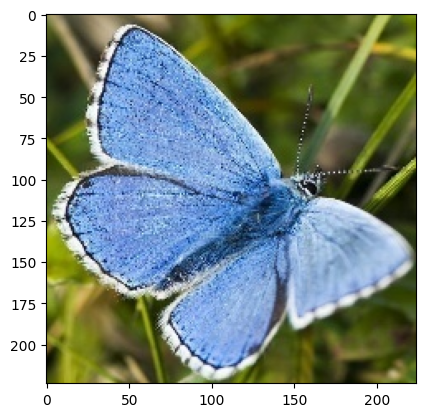

In [ ]:

current_dir = '/kaggle/input/butterfly-image-classification/train/'
file = current_dir + data_loc[1]
img = Image.open(file)
plt.imshow(img)

In [ ]:
def normalize_data(image):
    norm = tf.cast(image, tf.float32)/ 255.0
    return norm

In [ ]:
def get_image(split_type, index, df):
    current_dir = '/kaggle/input/butterfly-image-classification'
    current_dir = current_dir + '/'+ split_type + '/'
    file = current_dir + df[index]
    img = Image.open(file)
    img = np.array(img)
    img = tf.image.resize(img, (128,128))
    img = tf.convert_to_tensor(img)

    img = normalize_data(img)
    return img

In [ ]:
print(labels[63])

40


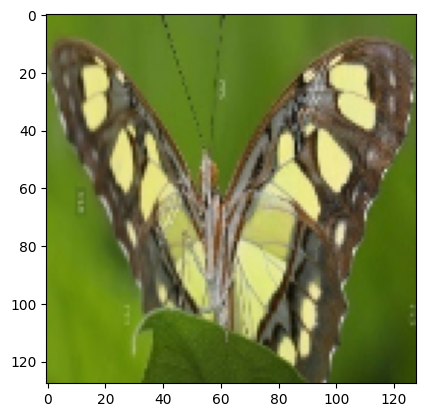

In [ ]:
img63 = get_image('train', 63, data_loc)
plt.imshow(img63)

# Preparing datasets
Function to one hot encode the integer labels representing the butterfly species

In [ ]:
def one_hot_encode(y):
    one_hot_y = tf.one_hot(indices=y, depth=75)
    return one_hot_y

In [ ]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    return image, label

Creating the dataset by accessing the image files and pairing with the one-hot encoded labels

In [ ]:
def create_dataset(X_df, y_df, split_type='train'):
    X = []
    y = []
    for i in range(len(X_df)):
        X.append(get_image(split_type, i, X_df))
        encoded_y = one_hot_encode(y_df[i])
        y.append(encoded_y)
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    aug_dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    return aug_dataset

In [ ]:
whole_set = create_dataset(data_loc, labels, 'train')
print(whole_set)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(75,), dtype=tf.float32, name=None))>


In [ ]:
def split_dataset(dataset, train_prop, dev_prop):
    train_split = int(train_prop * DATA_SIZE)
    dev_split = int(dev_prop * DATA_SIZE)

    dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=False)
    train_data = dataset.take(train_split)
    rest = dataset.skip(train_split)
    dev_data = rest.take(dev_split)
    test_data = rest.skip(dev_split)

    return train_data, dev_data, test_data

In [ ]:
train_set, dev_set, test_set = split_dataset(whole_set, 0.8, 0.2)

In [ ]:
train_set = (
    train_set
    .batch(BATCH_SIZE)
    .map(lambda x, y: (x, y),
        num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
dev_set = (
    dev_set
    .batch(BATCH_SIZE)
    .map(lambda x, y: (x, y),
        num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

# Building the model

In [ ]:
def build_custom_model(Dropout_fac=0.05):
    inputs = tf.keras.Input(shape=(128,128,3))
    conv1a = layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, padding="same")(inputs)
    conv1b = layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, padding="same")(conv1a)
    drop1 = layers.Dropout(rate=Dropout_fac)(conv1b)
    pool1 = layers.MaxPooling2D(pool_size=(2,2), strides=2, padding="valid")(drop1)

    conv2a = layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same")(pool1)
    conv2b = layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, padding="same")(conv2a)
    drop2 = layers.Dropout(rate=Dropout_fac)(conv2b)
    pool2 = layers.MaxPooling2D(pool_size=(2,2), strides=2, padding="valid")(drop2)

    conv3a = layers.Conv2D(filters=256, kernel_size=(3,3), strides=1, padding="same")(pool2)
    conv3b = layers.Conv2D(filters=256, kernel_size=(3,3), strides=1, padding="same")(conv3a)
    drop3 = layers.Dropout(rate=Dropout_fac)(conv3b)
    pool3 = layers.MaxPooling2D(pool_size=(2,2), strides=2, padding="valid")(drop3)




    F = layers.Flatten()(drop3)
    dense1 = layers.Dense(256, activation="relu")(F)
    outputs = layers.Dense(75, activation="linear")(dense1)

    model = keras.Model(inputs=inputs, outputs=outputs, name="Butterfly_model")
    loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        loss = loss_fn,
        optimizer = keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy"],
    )


    return model

In [ ]:
model = build_custom_model()
history = model.fit(train_set, epochs=2)

Epoch 1/2
41/41 ━━━━━━━━━━━━━━━━━━━━ 1732s 42s/step - accuracy: 0.0151 - loss: 35.6918
Epoch 2/2
41/41 ━━━━━━━━━━━━━━━━━━━━ 1715s 42s/step - accuracy: 0.0298 - loss: 4.3586


In [ ]:
model.save("model.keras")